# Streaming Module: Real-Time Rule Checking

This notebook demonstrates the **Streaming module** for real-time anomaly detection. The streaming engine evaluates rules against sensor data using efficient incremental algorithms.

## Key Features

- **O(1) Time Complexity**: Rolling statistics computed incrementally (River library)
- **Memory Efficient**: Fixed-size buffers regardless of window size
- **Single-Pass Processing**: Each data point is processed exactly once
- **Multiple Statistics**: mean, max, min, std, sum, count

## Rule Syntax

Rules use a `status.get()` API to query sensor values:

```python
def my_rule(status) -> str:
    # Point query (current value)
    temp = status.get("sensor_temp", "0")
    
    # Rolling statistics
    avg_temp = status.get("sensor_temp", "5m:", "mean")  # 5-minute average
    max_temp = status.get("sensor_temp", "10m:", "max")  # 10-minute max
    
    if temp and temp > 100:
        return "high_temperature_alert"
    return None
```


---
## 1. Setup

Import the streaming module and set up visualization.


In [1]:
import sys
from pathlib import Path

# Add workspace root to path for imports
workspace_root = Path.cwd().parent
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from src.streaming import RuleChecker, CheckerConfig, InMemoryEventSink, CSVEventSink

# Set up plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Streaming module imported")


Streaming module imported


---
## 2. Define Rules

Rules are Python functions that receive a `status` object and return an alert string or `None`.

### Rule Types

1. **Point queries**: Check the current sensor value
2. **Temporal queries**: Check rolling statistics over a time window


In [2]:
# Define test rules
rules = [
    {
        "rule_name": "high_temp_alert",
        "rule_description": "Alert when temperature exceeds 90 degrees C",
        "rule_body": """def high_temp_alert(status) -> str:
    temp = status.get("sensor_temp", "0")
    if temp and temp > 90:
        return "high_temperature_alert"
    return None
""",
    },
    {
        "rule_name": "sustained_high_pressure",
        "rule_description": "Alert when average pressure over 5 minutes exceeds 14 kg/cm2",
        "rule_body": """def sustained_high_pressure(status) -> str:
    avg_pressure = status.get("sensor_pressure", "5m:", "mean")
    if avg_pressure and avg_pressure > 14.0:
        return "sustained_high_pressure_alert"
    return None
""",
    },
    {
        "rule_name": "pressure_spike",
        "rule_description": "Alert when max pressure in last 10 minutes exceeds 15 kg/cm2",
        "rule_body": """def pressure_spike(status) -> str:
    max_pressure = status.get("sensor_pressure", "10m:", "max")
    if max_pressure and max_pressure > 15.0:
        return "pressure_spike_detected"
    return None
""",
    },
]

print(f"Defined {len(rules)} test rules:")
for rule in rules:
    print(f"  - {rule['rule_name']}: {rule['rule_description']}")


Defined 3 test rules:
  - high_temp_alert: Alert when temperature exceeds 90 degrees C
  - sustained_high_pressure: Alert when average pressure over 5 minutes exceeds 14 kg/cm2
  - pressure_spike: Alert when max pressure in last 10 minutes exceeds 15 kg/cm2


---
## 3. Generate Test Data

Create synthetic sensor data with known rule violations for testing.


In [3]:
def generate_test_data(num_samples=500, seed=42):
    """Generate synthetic data with known rule violations."""
    np.random.seed(seed)
    
    start_time = datetime(2024, 1, 1, 0, 0, 0)
    timestamps = [start_time + timedelta(minutes=i) for i in range(num_samples)]
    
    # Normal operation
    temp = np.full(num_samples, 85.0) + np.random.normal(0, 2, num_samples)
    pressure = np.full(num_samples, 13.0) + np.random.normal(0, 0.5, num_samples)
    
    # Inject violations
    # 1. High temp violation at samples 100-110
    temp[100:111] = 95.0 + np.random.normal(0, 1, 11)
    
    # 2. Sustained high pressure at samples 200-210
    pressure[200:211] = 14.5 + np.random.normal(0, 0.2, 11)
    
    # 3. Pressure spike at sample 350
    pressure[350] = 16.0
    
    df = pd.DataFrame(
        {"sensor_temp": temp, "sensor_pressure": pressure},
        index=pd.DatetimeIndex(timestamps),
    )
    
    return df

# Generate data
sensor_data = generate_test_data(num_samples=500)

print(f"Generated {len(sensor_data)} samples")
print(f"Data shape: {sensor_data.shape}")
print(f"\nFirst 5 rows:")
display(sensor_data.head())

print(f"\nData statistics:")
display(sensor_data.describe())


Generated 500 samples
Data shape: (500, 2)

First 5 rows:


,sensor_temp,sensor_pressure
2024-01-01 00:00:00,85.993428,13.463089
2024-01-01 00:01:00,84.723471,13.954708
2024-01-01 00:02:00,86.295377,12.300716
2024-01-01 00:03:00,88.046060,13.281485
2024-01-01 00:04:00,84.531693,12.674679



Data statistics:


,sensor_temp,sensor_pressure
count,500.000000,500.000000
mean,85.255710,13.058748
std,2.484174,0.545628
min,78.517465,11.651557
25%,83.644245,12.714573
50%,85.118439,13.028736
75%,86.374462,13.354259
max,96.399355,16.000000


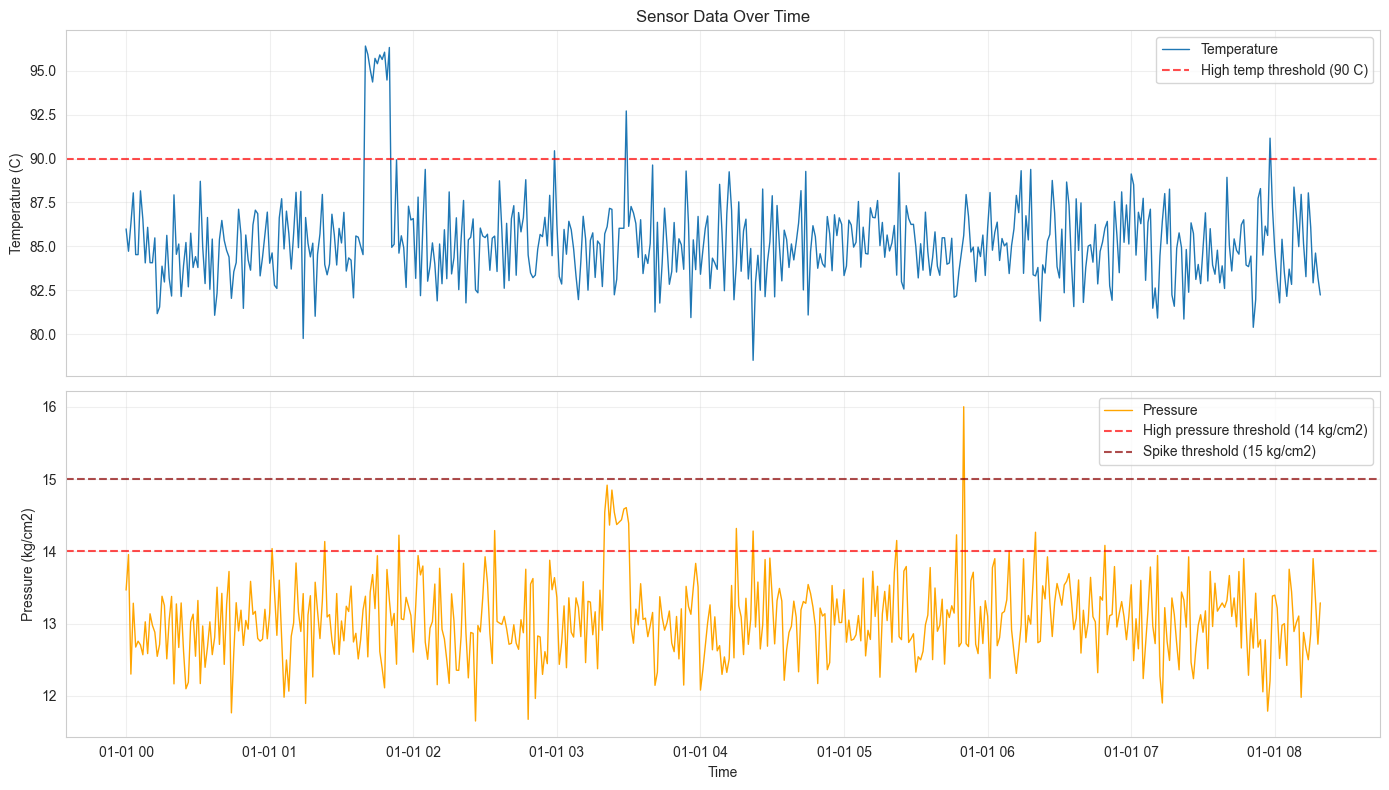

Injected violations:
  - High temperature spike around sample 100
  - Sustained high pressure around sample 200
  - Pressure spike at sample 350


In [4]:
# Visualize the test data
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Temperature
axes[0].plot(sensor_data.index, sensor_data['sensor_temp'], label='Temperature', linewidth=1)
axes[0].axhline(y=90, color='r', linestyle='--', label='High temp threshold (90 C)', alpha=0.7)
axes[0].set_ylabel('Temperature (C)')
axes[0].legend()
axes[0].set_title('Sensor Data Over Time')
axes[0].grid(True, alpha=0.3)

# Pressure
axes[1].plot(sensor_data.index, sensor_data['sensor_pressure'], label='Pressure', linewidth=1, color='orange')
axes[1].axhline(y=14, color='r', linestyle='--', label='High pressure threshold (14 kg/cm2)', alpha=0.7)
axes[1].axhline(y=15, color='darkred', linestyle='--', label='Spike threshold (15 kg/cm2)', alpha=0.7)
axes[1].set_ylabel('Pressure (kg/cm2)')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Injected violations:")
print("  - High temperature spike around sample 100")
print("  - Sustained high pressure around sample 200")
print("  - Pressure spike at sample 350")


---
## 4. Configure and Initialize RuleChecker

The `CheckerConfig` controls behavior:
- `granularity`: Time resolution of data (e.g., "1min")
- `skip_on_missing_data`: Whether to skip rules when data is missing
- `enable_caching`: Cache computed statistics for efficiency


In [5]:
# Configuration
config = CheckerConfig(
    granularity="1min",  # Data has 1-minute resolution
    skip_on_missing_data=True,
    enable_caching=True,
)

# Create checker with in-memory event sink
checker = RuleChecker(
    rules=rules,
    config=config,
    event_sink=InMemoryEventSink(),
)

print("RuleChecker initialized")
print(f"\nStatistics:")
stats = checker.get_statistics()
for key, value in stats.items():
    print(f"  {key}: {value}")


2025-12-14 17:16:43.297 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: high_temp_alert
2025-12-14 17:16:43.297 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: sustained_high_pressure
2025-12-14 17:16:43.298 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: pressure_spike
2025-12-14 17:16:43.300 | INFO     | src.streaming.infrastructure.buffered_status:extract_requirements_from_rules:259 - Extracted 3 unique requirements from 3 rules
2025-12-14 17:16:43.301 | DEBUG    | src.streaming.infrastructure.buffered_status:_initialize_buffers:75 - Initialized mean buffer for sensor_pressure with window 5m: (size=5)
2025-12-14 17:16:43.302 | DEBUG    | src.streaming.infrastructure.buffered_status:_initialize_buffers:75 - Initialized max buffer for sensor_pressure with window 10m: (size=10)
2025-12-14 17:16:43.302 | INFO     | src.streaming.infrastructure.buffered_status:__init__:52 

RuleChecker initialized

Statistics:
  num_rules: 3
  granularity: 0 days 00:01:00
  num_sensors_tracked: 0
  total_events: 0


---
## 5. Execute Rules

Process the sensor data in a single pass. The checker evaluates all rules at each timestamp.


In [6]:
%%time

# Run checker - single pass through data
events_df = checker.check_dataframe(sensor_data, verbose=False)

print(f"\nProcessing complete!")
print(f"Found {len(events_df)} rule trigger events")


2025-12-14 17:16:45.722 | INFO     | src.streaming.application.rule_checker:check_dataframe:108 - Starting single-pass check on 500 rows...
2025-12-14 17:16:45.745 | INFO     | src.streaming.application.rule_checker:check_dataframe:166 - ✓ Completed check: 500 rows processed, 34 events detected



Processing complete!
Found 34 rule trigger events
CPU times: user 18.1 ms, sys: 3.25 ms, total: 21.3 ms
Wall time: 24.6 ms


In [7]:
# Display event summary
if events_df is not None and len(events_df) > 0:
    print("Event Summary:")
    print("\nEvents by rule:")
    display(events_df['rule_name'].value_counts())
    
    print("\nAll Events:")
    display(events_df[['timestamp', 'rule_name', 'result', 'explanation']])
else:
    print("No rule triggers detected")


Event Summary:

Events by rule:


rule_name
high_temp_alert            14
sustained_high_pressure    10
pressure_spike             10
Name: count, dtype: int64


All Events:


,timestamp,rule_name,result,explanation
0,2024-01-01 01:40:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
1,2024-01-01 01:41:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
2,2024-01-01 01:42:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
3,2024-01-01 01:43:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
4,2024-01-01 01:44:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
5,2024-01-01 01:45:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
6,2024-01-01 01:46:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
7,2024-01-01 01:47:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
8,2024-01-01 01:48:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...
9,2024-01-01 01:49:00,high_temp_alert,high_temperature_alert,Rule 'high_temp_alert' returned: high_temperat...


---
## 6. Visualize Results

Plot the sensor data with rule trigger events highlighted.


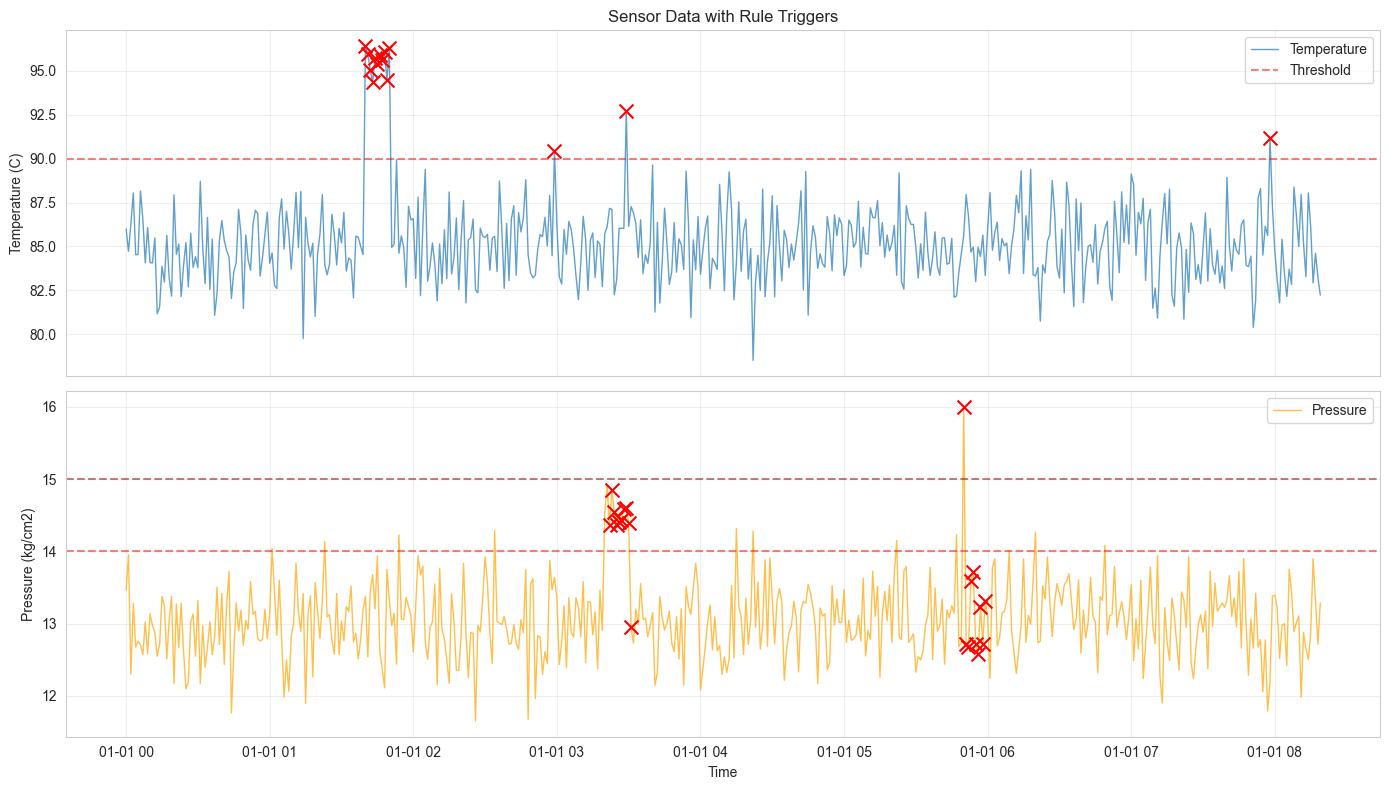

In [8]:
if len(events_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Temperature with events
    axes[0].plot(sensor_data.index, sensor_data['sensor_temp'], label='Temperature', linewidth=1, alpha=0.7)
    axes[0].axhline(y=90, color='r', linestyle='--', label='Threshold', alpha=0.5)
    
    # Mark temp-related events
    temp_events = events_df[events_df['rule_name'].str.contains('temp')]
    if len(temp_events) > 0:
        for _, event in temp_events.iterrows():
            trigger_time = event['timestamp']
            if trigger_time in sensor_data.index:
                trigger_value = sensor_data.loc[trigger_time, 'sensor_temp']
                axes[0].scatter([trigger_time], [trigger_value], 
                               color='red', s=100, marker='x', zorder=5)
    
    axes[0].set_ylabel('Temperature (C)')
    axes[0].legend()
    axes[0].set_title('Sensor Data with Rule Triggers')
    axes[0].grid(True, alpha=0.3)
    
    # Pressure with events
    axes[1].plot(sensor_data.index, sensor_data['sensor_pressure'], label='Pressure', linewidth=1, alpha=0.7, color='orange')
    axes[1].axhline(y=14, color='r', linestyle='--', alpha=0.5)
    axes[1].axhline(y=15, color='darkred', linestyle='--', alpha=0.5)
    
    # Mark pressure-related events
    pressure_events = events_df[events_df['rule_name'].str.contains('pressure')]
    if len(pressure_events) > 0:
        for _, event in pressure_events.iterrows():
            trigger_time = event['timestamp']
            if trigger_time in sensor_data.index:
                trigger_value = sensor_data.loc[trigger_time, 'sensor_pressure']
                axes[1].scatter([trigger_time], [trigger_value], 
                               color='red', s=100, marker='x', zorder=5)
    
    axes[1].set_ylabel('Pressure (kg/cm2)')
    axes[1].set_xlabel('Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No events to visualize")


---
## 7. Advanced Usage

### Event Sinks

Events can be routed to different destinations:
- `InMemoryEventSink`: Store events in memory (for testing)
- `CSVEventSink`: Write events to a CSV file (for logging)

### Statistics

Track rule evaluation statistics over time.


In [9]:
# Get final statistics
final_stats = checker.get_statistics()

print("Final Statistics:")
for key, value in final_stats.items():
    print(f"  {key}: {value}")


Final Statistics:
  num_rules: 3
  granularity: 0 days 00:01:00
  num_sensors_tracked: 2
  total_events: 34


In [12]:
# Example: Using CSV Event Sink
csv_sink = CSVEventSink(filepath="./events.csv")

checker_with_csv = RuleChecker(
    rules=rules,
    config=config,
    event_sink=csv_sink,
)

# Process data (events will be written to CSV)
_ = checker_with_csv.check_dataframe(sensor_data, verbose=False)

# Flush buffered events to disk (required before reading)
csv_sink.flush()

print("Events written to ./events.csv")

# Display CSV contents
events_csv = pd.read_csv("./events.csv")
print(f"\nCSV contents ({len(events_csv)} events):")
display(events_csv.head(10))


2025-12-14 17:19:05.496 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: high_temp_alert
2025-12-14 17:19:05.497 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: sustained_high_pressure
2025-12-14 17:19:05.498 | DEBUG    | src.streaming.application.rule_checker:_compile_rules:90 - Compiled rule: pressure_spike
2025-12-14 17:19:05.499 | INFO     | src.streaming.infrastructure.buffered_status:extract_requirements_from_rules:259 - Extracted 3 unique requirements from 3 rules
2025-12-14 17:19:05.501 | DEBUG    | src.streaming.infrastructure.buffered_status:_initialize_buffers:75 - Initialized mean buffer for sensor_pressure with window 5m: (size=5)
2025-12-14 17:19:05.503 | DEBUG    | src.streaming.infrastructure.buffered_status:_initialize_buffers:75 - Initialized max buffer for sensor_pressure with window 10m: (size=10)
2025-12-14 17:19:05.503 | INFO     | src.streaming.infrastructure.buffered_status:__init__:52 

Events written to ./events.csv

CSV contents (34 events):


,timestamp,rule_name,triggered,result,sensor_values,explanation,rule_description
0,2024-01-01 01:40:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 96.399355436586, 'sensor_press...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
1,2024-01-01 01:41:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.92463368291277, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
2,2024-01-01 01:42:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.05963036992017, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
3,2024-01-01 01:43:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 94.35306322229442, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
4,2024-01-01 01:44:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.6982233136136, 'sensor_pres...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
5,2024-01-01 01:45:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.39348538542176, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
6,2024-01-01 01:46:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.89519322002774, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
7,2024-01-01 01:47:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 95.63517180168196, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
8,2024-01-01 01:48:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 96.04955271531934, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C
9,2024-01-01 01:49:00,high_temp_alert,True,high_temperature_alert,"{'sensor_temp': 94.46476478843944, 'sensor_pre...",Rule 'high_temp_alert' returned: high_temperat...,Alert when temperature exceeds 90 degrees C


---
## 8. Time Expression Reference

The `status.get()` method supports the following time expressions:

| Expression | Description | Example |
|------------|-------------|---------|
| `"0"` | Current value (point query) | `status.get("temp", "0")` |
| `"5m:"` | Last 5 minutes | `status.get("temp", "5m:", "mean")` |
| `"1h:"` | Last 1 hour | `status.get("temp", "1h:", "max")` |
| `"30m:"` | Last 30 minutes | `status.get("temp", "30m:", "std")` |

### Available Statistics

| Statistic | Description |
|-----------|-------------|
| `mean` | Average value over window |
| `max` | Maximum value over window |
| `min` | Minimum value over window |
| `std` | Standard deviation over window |
| `sum` | Sum of values over window |
| `count` | Number of values in window |


---
## 9. Summary

This notebook demonstrated the streaming rule checker:

1. **Rule Definition**: Simple Python functions using `status.get()` API
2. **Configuration**: Granularity, caching, and missing data handling
3. **Data Processing**: Single-pass evaluation with O(1) rolling statistics
4. **Event Analysis**: Results collection and visualization
5. **Event Sinks**: In-memory and CSV output options

The streaming module is designed for high-throughput, low-latency anomaly detection in industrial monitoring systems.
